Enable notebook to graph inline

In [159]:
%matplotlib inline

Import dependancies.

In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

Expansion specific global variables.

In [161]:
EXPANSION = 'MID'
CSV_NAMES = {'MID':"game_data_public.MID.PremierDraft.csv"}
DECK_COLUMNS = {'MID': [562,834]}
#To get information on new set use: df.info(max_cols=1106)

## Import 17lands data

Define data types for importing 17lands data.

In [162]:
MAX_MULLIGANS = 7
MAX_TURNS = 30

BASE_COLS = {
    'draft_id': str,
    'history_id': int,
    'time': str,
    'expansion': str,
    'format': str,
    'user_rank': str,
    'oppo_rank': str,
    'game_index': 'int8',
    'user_deck_colors': str,
    'oppo_deck_colors': str,
    'user_mulligans': 'int8',
    'oppo_mulligans': 'int8',
    'on_play': bool,
    'turns': 'int8',
    'won': bool,
    'missing_diffs': 'int8',
}

PER_TURN_COLS = {
    'cards_drawn': str,
    'cards_discarded': str,
    'lands_played': str,
    'cards_foretold': str,
    'creatures_cast': str,
    'non_creatures_cast': str,
    'user_instants_sorceries_cast': str,
    'oppo_instants_sorceries_cast': str,
    'user_abilities': str,
    'oppo_abilities': str,
    'user_cards_learned': str,
    'oppo_cards_learned': str,
    'creatures_attacked': str,
    'creatures_blocked': str,
    'creatures_unblocked': str,
    'creatures_blocking': str,
    'player_combat_damage_dealt': 'int8',
    'user_creatures_killed_combat': str,
    'oppo_creatures_killed_combat': str,
    'user_creatures_killed_non_combat': str,
    'oppo_creatures_killed_non_combat': str,
    'user_mana_spent': 'int8',
    'oppo_mana_spent': 'int8',
    'eot_user_cards_in_hand': str,
    'eot_oppo_cards_in_hand': str,
    'eot_user_lands_in_play': str,
    'eot_oppo_lands_in_play': str,
    'eot_user_creatures_in_play': str,
    'eot_oppo_creatures_in_play': str,
    'eot_user_non_creatures_in_play': str,
    'eot_oppo_non_creatures_in_play': str,
    'eot_user_life': 'int8',
    'eot_oppo_life': 'int8',
}

SUMMARY_COLS = {
    'cards_drawn': 'int8',
    'cards_discarded': 'int8',
    'lands_played': 'int8',
    'cards_foretold': 'int8',
    'creatures_cast': 'int8',
    'non_creatures_cast': 'int8',
    'instants_sorceries_cast': 'int8',
    'cards_learned': 'int8',
    'mana_spent': 'int16',
}

def get_dtypes():
    dtypes = BASE_COLS.copy()

    for x in range(1, MAX_MULLIGANS+1):
        dtypes[f'candidate_hand_{x}'] = str
    dtypes['opening_hand'] = str

    for turn in range(1, MAX_TURNS+1):
        for player in ['user', 'oppo']:
            for k, v in PER_TURN_COLS.items():
                dtypes[f'{player}_turn_{turn}_{k}'] = v
            dtypes[f'{player}_turn_{turn}_eot_oppo_cards_in_hand'] = 'int8'
        dtypes[f'oppo_turn_{turn}_cards_drawn'] = 'int8'

    for player in ['user', 'oppo']:
        for col in SUMMARY_COLS:
            dtypes[f'{player}_total_{col}'] = 'int8'

    return dtypes

Load 17lands data into dataframe.

In [163]:
dtypes=get_dtypes()
df = pd.read_csv(CSV_NAMES['MID'], dtype=dtypes)

/Users/dommil/Documents/projects/dafter/jupyter/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Helper functions

Create a subset of entire DataFrame that contains just specified card (eg. `'Siege Zombie'`).

In [164]:
def decks_with_card(card):
    #select just deck information
    decks = df.iloc[:,DECK_COLUMNS[EXPANSION][0]:DECK_COLUMNS[EXPANSION][1]]
    #select decks that contain specified card
    decks = decks[decks['deck_' + card] > 0]
    return decks

Create a subset of entire DataFrame that contains specific color pairing (eg. `'UW'`).

In [194]:
def decks_with_cp(cp):
    #select decks that contain specified color pairing
    decks = df[df['main_colors'] == cp]
    #select just deck information
    decks = decks.iloc[:,DECK_COLUMNS[EXPANSION][0]:DECK_COLUMNS[EXPANSION][1]]
    return decks

Create scatter plot of decks. Returns DataFrame that is shape (n, 2).

In [285]:
def graph_scatter(decks, df=df):
    # define transform
    svd = TruncatedSVD()
    # prepare transform on dataset
    svd.fit(decks)
    # apply transform to dataset
    transformed = svd.transform(decks)
    #change to a DataFrame, fixing labels for t
    t = pd.DataFrame(data=transformed, columns=['a','b'], index=decks.index)
    #C parameter is the winrate of deck
    plt.scatter(t['a'], t['b'], c=df.loc[decks.index,'user_win_rate_bucket'], cmap='viridis')
    plt.grid()
    return t

Show a list of the average number of cards within a given cluster of transform 't' defined by the boundries amin, amax, bmin and bmax.

In [303]:
def card_avgs(decks, t, amin, amax, bmin, bmax, num_cards=50):
    #find decks within the boundries
    t = t[t['a']>amin]
    t = t[t['a']<amax]
    t = t[t['b']>bmin]
    t = t[t['b']<bmax]
    #pull out the corresponding rows from decks
    decks = decks.loc[t.index]
    #remove any columns with all zeros
    decks = decks.loc[:, (decks != 0).any(axis=0)]
    print(f'{decks.shape[0]} decks in area. With average win rate of {df.loc[decks.index]["user_win_rate_bucket"].mean() * 100}%')
    #take the mean of each column
    decks = decks.mean()
    #sort by largest to lowest
    decks = decks.sort_values(ascending=False)
    print(decks.head(num_cards))
    #graph histogram
    #plt.hist(deck, orientation='horizontal')
    #sns.displot(deck.head(), x=deck.head().index, orientation='horizontal')


# Analysis

Use the below cells to analyze decks!

In [283]:
decks = decks_with_card('Siege Zombie')
#decks = decks_with_cp('WG')

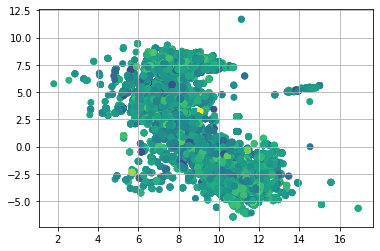

In [286]:
t = graph_scatter(decks)

In [304]:
card_avgs(decks, t, 9, 9.2, 3, 3.5)

2 decks in area. With average win rate of 100.0%
deck_Swamp                         7.0
deck_Plains                        6.0
deck_Island                        4.0
deck_Sungold Barrage               2.0
deck_Blood Pact                    1.0
deck_Mask of Griselbrand           1.0
deck_Vengeful Strangler            1.0
deck_Vampire Interloper            1.0
deck_Soul-Guide Gryff              1.0
deck_Siege Zombie                  1.0
deck_Ritual Guardian               1.0
deck_Mystic Skull                  1.0
deck_Morkrut Behemoth              1.0
deck_Liesa, Forgotten Archangel    1.0
deck_Celestus Sanctifier           1.0
deck_Hobbling Zombie               1.0
deck_Heirloom Mirror               1.0
deck_Flip the Switch               1.0
deck_Firmament Sage                1.0
deck_Falcon Abomination            1.0
deck_Ecstatic Awakener             1.0
deck_Duelcraft Trainer             1.0
deck_Diregraf Horde                1.0
deck_Defenestrate                  1.0
deck_Vivisectio